In [73]:
import re
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Clear and normalize dataset

In [74]:
def name2celltype(cell):
    return cell.split('_')[0]

def name2lineage(cell):
    if cell.startswith('B.'):
        return 'B'
    if cell.startswith('T4'):
        return 'T4'
    if cell.startswith('T8'):
        return 'T8'
    if cell.startswith('mDC') or cell.startswith('pDC'):
        return 'DC'
    if cell.startswith('MO.'):
        return 'MO'
    if cell.startswith('NK'):
        return 'NK'
    if cell.startswith('GN'):
        return 'GN'
    if cell.startswith('Erythrocyte'):
        return 'ER'
    if cell.startswith('Thrombocyte'):
        return 'THRC'
    if cell.startswith('Th'):
        return 'TH'
    return 'Others'

In [75]:
def col_filter(col_name, state='steady-state'):
    if state == 'steady-state':
        if not re.search(r'\(steady-state\)', col_name):
            return False
    elif state == 'activated':
        if not re.search(r'\(activated\)', col_name):
            return False
    else:
        if not re.search(r'(\(steady-state\))|(\(activated\))', col_name):
            return False
    if re.match(r'(Erythrocyte)|(Thrombocyte)', col_name):
        return False
    return True

In [64]:
df_article = pd.read_csv('./supp/proteinGroups.txt', sep='\t', low_memory=False)

In [65]:
len_before = df_article.shape[0]
df_article = df_article[df_article['Potential.contaminant'] != '+']
len_after = df_article.shape[0]
print(f'Removed {len_before - len_after} potential contaminant proteins. Now we have {len_after} proteins')

Removed 352 potential contaminant proteins. Now we have 37088 proteins


In [66]:
len_before = df_article.shape[0]
df_article = df_article[df_article['Reverse'] != '+']
len_after = df_article.shape[0]
print(f'Removed {len_before - len_after} decoy proteins. Now we have {len_after} proteins')

Removed 16426 decoy proteins. Now we have 20662 proteins


In [67]:
intensity_columns = [c for c in df_article.columns if c.startswith('LFQ.intensity') and not 
                     c.startswith('LFQ.intensity.Library')]
new_intensity_columns = [c.replace('LFQ.intensity.', '') for c in intensity_columns]
df_article = df_article[['Protein.IDs', 'Protein.names', 'Gene.names'] + intensity_columns]
df_article.columns = ['protein_id', 'protein_name', 'gene'] + new_intensity_columns

intensity2lineage = {ic : name2lineage(ic) for ic in new_intensity_columns}
intensity2celltype = {ic : name2celltype(ic) for ic in new_intensity_columns}

In [68]:
len(intensity_columns)

175

In [69]:
len_before = df_article.shape[0]
df_article = df_article[df_article.protein_name.notnull()]
len_after = df_article.shape[0]
print(f'Removed {len_before - len_after} proteins with no name. Now we have {len_after} proteins')

Removed 3043 proteins with no name. Now we have 17619 proteins


In [76]:
columns = list(filter(col_filter, df_article.columns))
cell_types = set(map(lambda col: re.sub(r'_\d\d.+', '', col), columns))

In [77]:
df = df_article.copy()
df = df[columns]
df['quality'] = 0

In [78]:
cell_type_groups = {}
for cell_type in cell_types:
    group = list(filter(lambda col: re.match(cell_type + '_', col), columns))
    df['quality'] = df['quality'] + (df[group] == 0).sum(axis=1) <= 2

In [79]:
df_article = df_article[df['quality'].astype(bool)]

In [80]:
df_article[new_intensity_columns] = df_article[new_intensity_columns].applymap(np.log1p)

print('Successfully converted intensities to log1p scale')

Successfully converted intensities to log1p scale


In [81]:
df_article['gene'] = df_article.gene.fillna('')

In [82]:
df_article.shape

(9002, 178)

### PCA

Take just cells in a steady-state, cause otherwise, PC1 will be "cell state"

In [18]:
df_article.head(3)

,protein_id,protein_name,gene,B.memory_01 (activated),B.memory_02 (activated),B.memory_03 (activated),B.memory_04 (activated),B.naive_01 (activated),B.naive_02 (activated),B.naive_03 (activated),...,NK.dim_03 (steady-state),NK.dim_04 (steady-state),Erythrocyte_01 (steady-state),Erythrocyte_02 (steady-state),Erythrocyte_03 (steady-state),Erythrocyte_04 (steady-state),Thrombocyte_01 (steady-state),Thrombocyte_02 (steady-state),Thrombocyte_03 (steady-state),Thrombocyte_04 (steady-state)
5,O60462-5;A0A024R412;O60462-4;O60462;A0A024R3W6...,Neuropilin-2,NRP2,18.118508,16.827756,0.000000,18.122261,0.000000,17.306183,14.411762,...,15.855770,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6,A0A024R4E5;Q00341;Q00341-2;H0Y394;H7C0A4;C9J5E...,Vigilin,HDLBP,22.592357,22.408813,22.638790,22.266308,22.302657,22.221437,22.313969,...,21.757873,21.759861,0.0,0.0,0.0,0.0,17.643282,17.477995,17.614432,17.366621
7,A0A024R4K9;Q9BXJ8;A0A087WZA9;A0A087X266;Q9BXJ8...,Transmembrane protein 120A,TMPIT;TMEM120A,17.101035,18.128147,18.462974,18.211107,17.999513,18.174089,17.587329,...,16.267808,17.492495,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


1) PCA of all of the samples

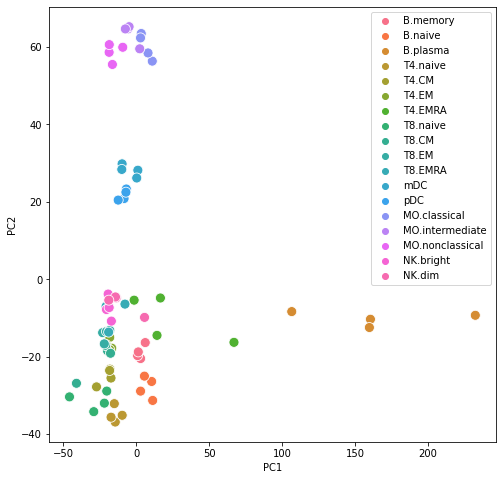

In [19]:
skipped_lineages = set(['ER', 'THRC', 'TH', 'Others'])
pca_columns = [ci for ci in new_intensity_columns if name2lineage(ci) not in skipped_lineages and
               'steady-state' in ci]
pca = PCA(n_components=4)
X = df_article[pca_columns].values.T
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca.fit(X)
pca_data = pca.transform(X)

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1],
                hue=[name2celltype(ic) for ic in pca_columns],
                s=100, color="1", ax=ax)
ax.set(xlabel='PC1', ylabel='PC2')
plt.show()

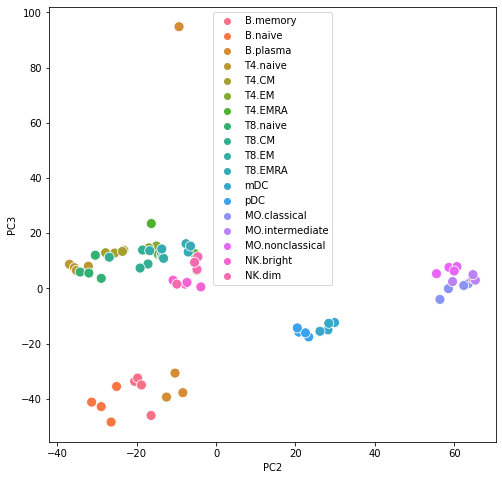

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=pca_data[:, 1], y=pca_data[:, 2],
                hue=[name2celltype(ic) for ic in pca_columns],
                s=100, color="1", ax=ax)
ax.set(xlabel='PC2', ylabel='PC3')
plt.show()

In [21]:
pca.explained_variance_ratio_

array([0.22366538, 0.11343069, 0.05242038, 0.04470909])

2) PCA of averages samples by cell types

In [22]:
skipped_lineages = set(['ER', 'THRC', 'TH', 'Others'])
pca_columns_avg = sorted(list(set([ci.split('_')[0] for ci in new_intensity_columns if 
                       name2lineage(ci) not in skipped_lineages and 'steady-state' in ci])))
dataset = np.zeros(shape=[len(pca_columns_avg), df_article.shape[0]])
for i, c_avg in enumerate(pca_columns_avg):
    columns = [c for c in df_article.columns if c.startswith(c_avg) and 'steady-state' in c]
    dataset[i, :] = df_article[columns].values.mean(axis=1)

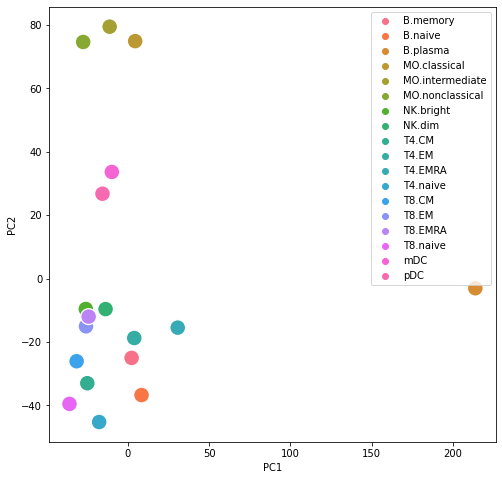

In [23]:
pca = PCA(n_components=4)
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)
pca.fit(dataset)
pca_data = pca.transform(dataset)
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1],
                hue=pca_columns_avg,
                s=250, color="1", ax=ax)
ax.set(xlabel='PC1', ylabel='PC2')
plt.show()

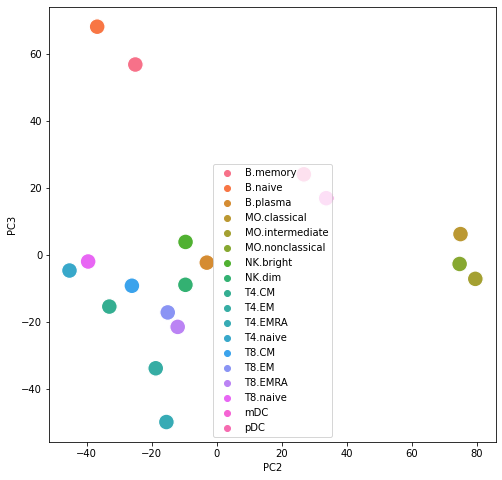

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=pca_data[:, 1], y=pca_data[:, 2],
                hue=pca_columns_avg,
                s=250, color="1", ax=ax)
ax.set(xlabel='PC2', ylabel='PC3')
plt.show()

In [25]:
pca.explained_variance_ratio_

array([0.34150192, 0.17839623, 0.08760163, 0.06523763])

### Proteins clustering

Results from article (minimum module size of 20): the algorithm assigned the 6,982 proteins to 47 modules containing 23–725 proteins.

In [26]:
import sys
print({sys.executable})

{'/usr/bin/python3'}


In [27]:
skipped_lineages = set(['ER', 'THRC', 'TH', 'Others'])
df_article['id_and_gene'] = [f'{t[0]}_{t[1]}' for t in zip(df_article.index.values, df_article.gene.values)]
cluster_columns = [ci for ci in new_intensity_columns if 'steady-state' in ci]
cluster_columns = ['id_and_gene']  + [ci for ci in cluster_columns if name2lineage(ci) not in skipped_lineages]

In [28]:
df_article[cluster_columns].to_csv('./data_to_cluster3.csv', sep='\t', index=False)

In [29]:
! python ./iterativeWGCNA/run_iterative_wgcna.py -i ./data_to_cluster2.csv -o wgcna_result2

python: can't open file './iterativeWGCNA/run_iterative_wgcna.py': [Errno 2] No such file or directory


In [30]:
wgcna_result = pd.read_csv('./wgcna_result3/final-membership.txt', sep='\t')
print(wgcna_result.shape[0])
wgcna_result.head(3)

FileNotFoundError: [Errno 2] No such file or directory: './wgcna_result3/final-membership.txt'

In [ ]:
df_article['module'] = wgcna_result['Module']
df_article['module_kme'] = wgcna_result['kME']

In [ ]:
#df_article[['module', 'gene']].groupby('module').count()
print(f"Cassified proteins: {df_article[df_article.module != 'UNCLASSIFIED'].shape[0]}")
tmp_df = df_article[df_article.module != 'UNCLASSIFIED'].groupby('module').count().reset_index()[['module', 'gene']]
print(f"Total modules: {tmp_df.shape[0]}")
print(f"Min module size: {tmp_df.gene.min()}")
print(f"Max module size: {tmp_df.gene.max()}")
print(f"Avg module size: {tmp_df.gene.mean()}")

In [ ]:
tmp_df

In [ ]:
def print_neighbours(df, gene, cluster_column, n=100):
    gene_cid = df[df.gene == gene][cluster_column].values[0]
    gene_protein_name = df[df.gene == gene]['protein_name'].values[0]
    print(f'{gene} (cluster id: {gene_cid}), {gene_protein_name}')
    print(f'Neighbours:')
    tmp_df = df[df[cluster_column] == gene_cid][['gene', 'protein_name', cluster_column]].values[:n]
    for g, protein_name, cid in tmp_df:
        print(f'\t{g} (cluster id: {cid}), {protein_name}')

def print_clusters_of(df, genes, cluster_column):
    tmp_df = df[df.gene.isin(genes)][['gene', 'protein_name', cluster_column]].values
    for g, protein_name, cid in tmp_df:
        print(f'{g} (cluster id: {cid}), {protein_name}')

In [ ]:
df_article[df_article.module == 'P1_I7_M3'][['protein_name', 'gene', 'module', 'module_kme']]

blue-cicle genes from article

In [ ]:
genes = ['GATA3', 'CD247', 'THEMIS', 'PLCG1', 'PRKCQ', 'TCRA', 'LCK', 'LAT', 'CD3G', 'GRAP2',
        'SKAP1', 'CD3D', 'CD3E', 'TRAT1', 'TESPA1', 'LIME1', 'TUBA4A', 'UBASH3AT', 'ZAP70']
print_clusters_of(df_article, genes, 'module')

orange-cicle genes from article

In [ ]:
genes = ['CYBA', 'PLCG2', 'CYBB', 'LYN', 'STX7', 'SYK', 'NCF1', 'STX12', 'GSN', 'MARCKS',
        'PHPT1', 'ATP6V0A1', 'NCF4', 'VAV3', 'FCGR2B']
print_clusters_of(df_article, genes, 'module')

#### Bad tries of clustering (HDBSCAN, hierarchical clustering)

In [ ]:
columns_avg = [ci for ci in new_intensity_columns if 'steady-state' in ci]

clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
scaler = StandardScaler()
X = scaler.fit_transform(df_article[columns].values)
cluster_labels = clusterer.fit_predict(X)
df_article['hdbscan_cluster_id'] = cluster_labels

In [ ]:
df_article[df_article.gene == 'LAT'].hdbscan_cluster_id

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Protein dendogram")
dend = shc.dendrogram(shc.linkage(df_article[cluster_columns].values, method='ward'))

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

### Heatmap

In [83]:
skipped_lineages = set(['ER', 'THRC', 'TH', 'Others'])
columns_avg = sorted(list(set([ci.split('_')[0] for ci in new_intensity_columns if 
                          name2lineage(ci) not in skipped_lineages and 'steady-state' in ci and 'plasma' not in ci])))
for i, c_avg in enumerate(columns_avg):
    columns = [c for c in df_article.columns if c.startswith(c_avg) and 'steady-state' in c]
    df_article[c_avg] = df_article[columns].values.mean(axis=1)

In [84]:
top_genes = [
    'CD3E', 'CD3D', 'THEMIS', 'CD28',
    'GATA3', 'FOXP3', 'IL7R', 'STAT4',
    'NCR1', 'TBX21', 'GZMB', 'CD8A',
    'IRF4', 'CD22', 'PAX5', 'CD79A', 'CD40', 'CLEC4C',
    'TLR7', 'CD14', 'TLR2', 'EPX', 'NCF2', 'TLR8', 'TLR6',
    'CD68', 'CD36', 'CLIC4', 'CYBB', 'NCF1', 'IRF8', 'GRN',
    'CCR3', 'CD177', 'GAPDH', 'CD4', 'CD8B', 'TBX21', 'THEMIS',
    'SYK', 'CD79A', 'TLR2'
]

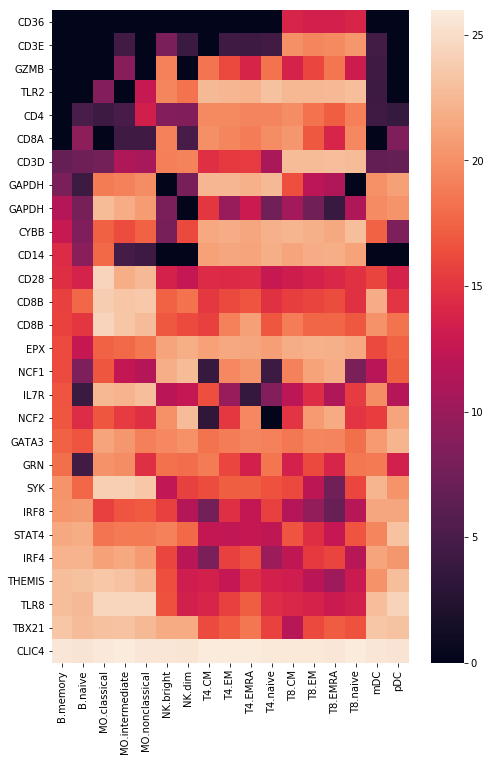

In [85]:
data = df_article[df_article.gene.isin(top_genes)][columns_avg].sort_values(columns_avg)
fig, ax = plt.subplots(figsize=(8, 12))
sns.heatmap(data, ax=ax, yticklabels=df_article[df_article.gene.isin(top_genes)].gene)
plt.show()

### Heatmap 2

In [32]:
columns = list(filter(col_filter, df_article.columns))
cell_types = sorted(set(map(lambda col: re.sub(r'_\d\d.+', '', col), columns)))

In [33]:
df_heatmap = pd.DataFrame(index=df_article['protein_name'])
df_heatmap = (df_heatmap.T / df_heatmap.T.max()).T

In [34]:
for cell_type in cell_types:
    group = list(filter(lambda col: re.match(cell_type + '_', col), columns))
    df_heatmap[cell_type] = df_article[group].mean(axis=1).values

In [35]:
proteins = set()
norm_coef = df_heatmap.mean(axis=1)
for i in range(len(cell_types)):
    diff = np.abs(df_heatmap[cell_types[i]] - 
                  df_heatmap[cell_types[:i] + cell_types[i+1:]].mean(axis=1)) / norm_coef
    diff_proteins = diff.sort_values(ascending=False).index[:5]
    proteins |= set(diff_proteins)

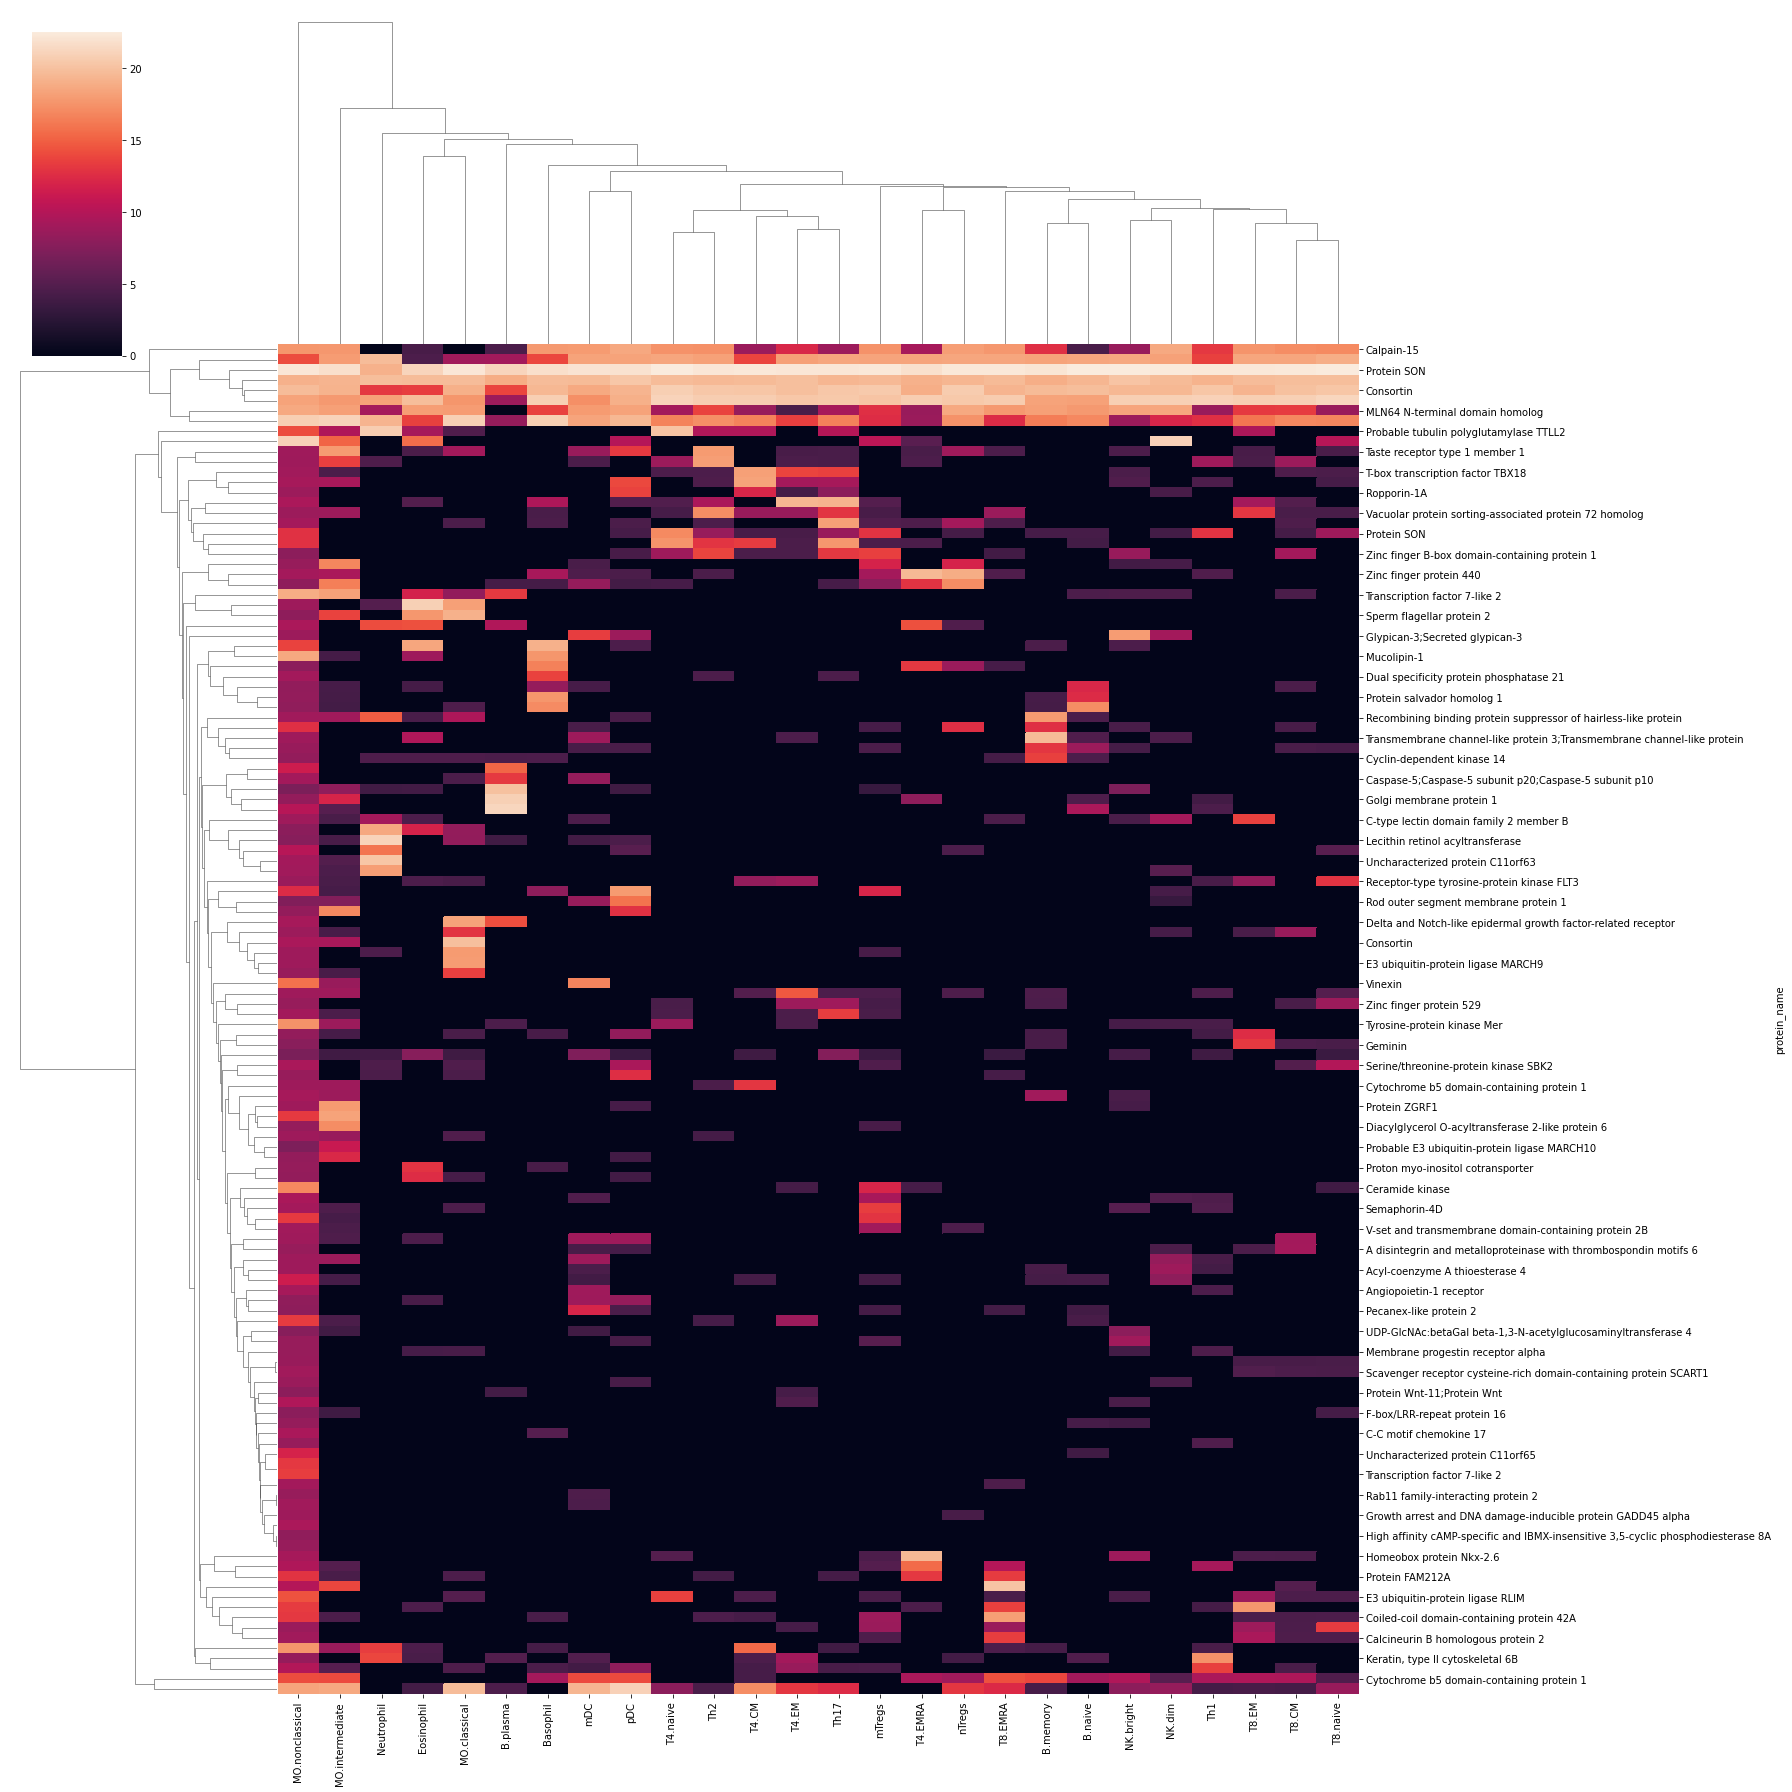

In [36]:
sns.clustermap(df_heatmap.loc[pd.Index(proteins)], figsize=(25,25))
plt.show()

### Comparing with our MaxQuant results

In [37]:
def col_rename(col):
    cell, ctype, state, n = re.search(r'(.+?)_(.+?)_(.+?)_(.+)', col).groups()
    return f'{cell}.{ctype}_{n} ({state})'

In [38]:
df_myquant = pd.read_csv('paper/combined/txt/proteinGroups.txt', sep='\t', low_memory=False)
df_myquant.index = df_myquant['Protein IDs']

In [39]:
intensity_columns = [c for c in df_myquant.columns if c.startswith('LFQ intensity')]
new_intensity_columns = [c.replace('LFQ intensity ', '') for c in intensity_columns]
new_intensity_columns = list(map(col_rename, new_intensity_columns))
df_myquant = df_myquant[['Protein IDs', 'Protein names', 'Gene names'] + intensity_columns]
df_myquant.columns = ['protein_id', 'protein_name', 'gene'] + new_intensity_columns

df_myquant[new_intensity_columns] = df_myquant[new_intensity_columns].applymap(np.log1p)

In [40]:
df_article_comp = df_article.copy()
df_article_comp.index = df_article_comp['protein_id']

In [41]:
common_proteins = pd.Index(set(df_article['protein_id']) & set(df_myquant.index))

In [42]:
len(common_proteins)

1175

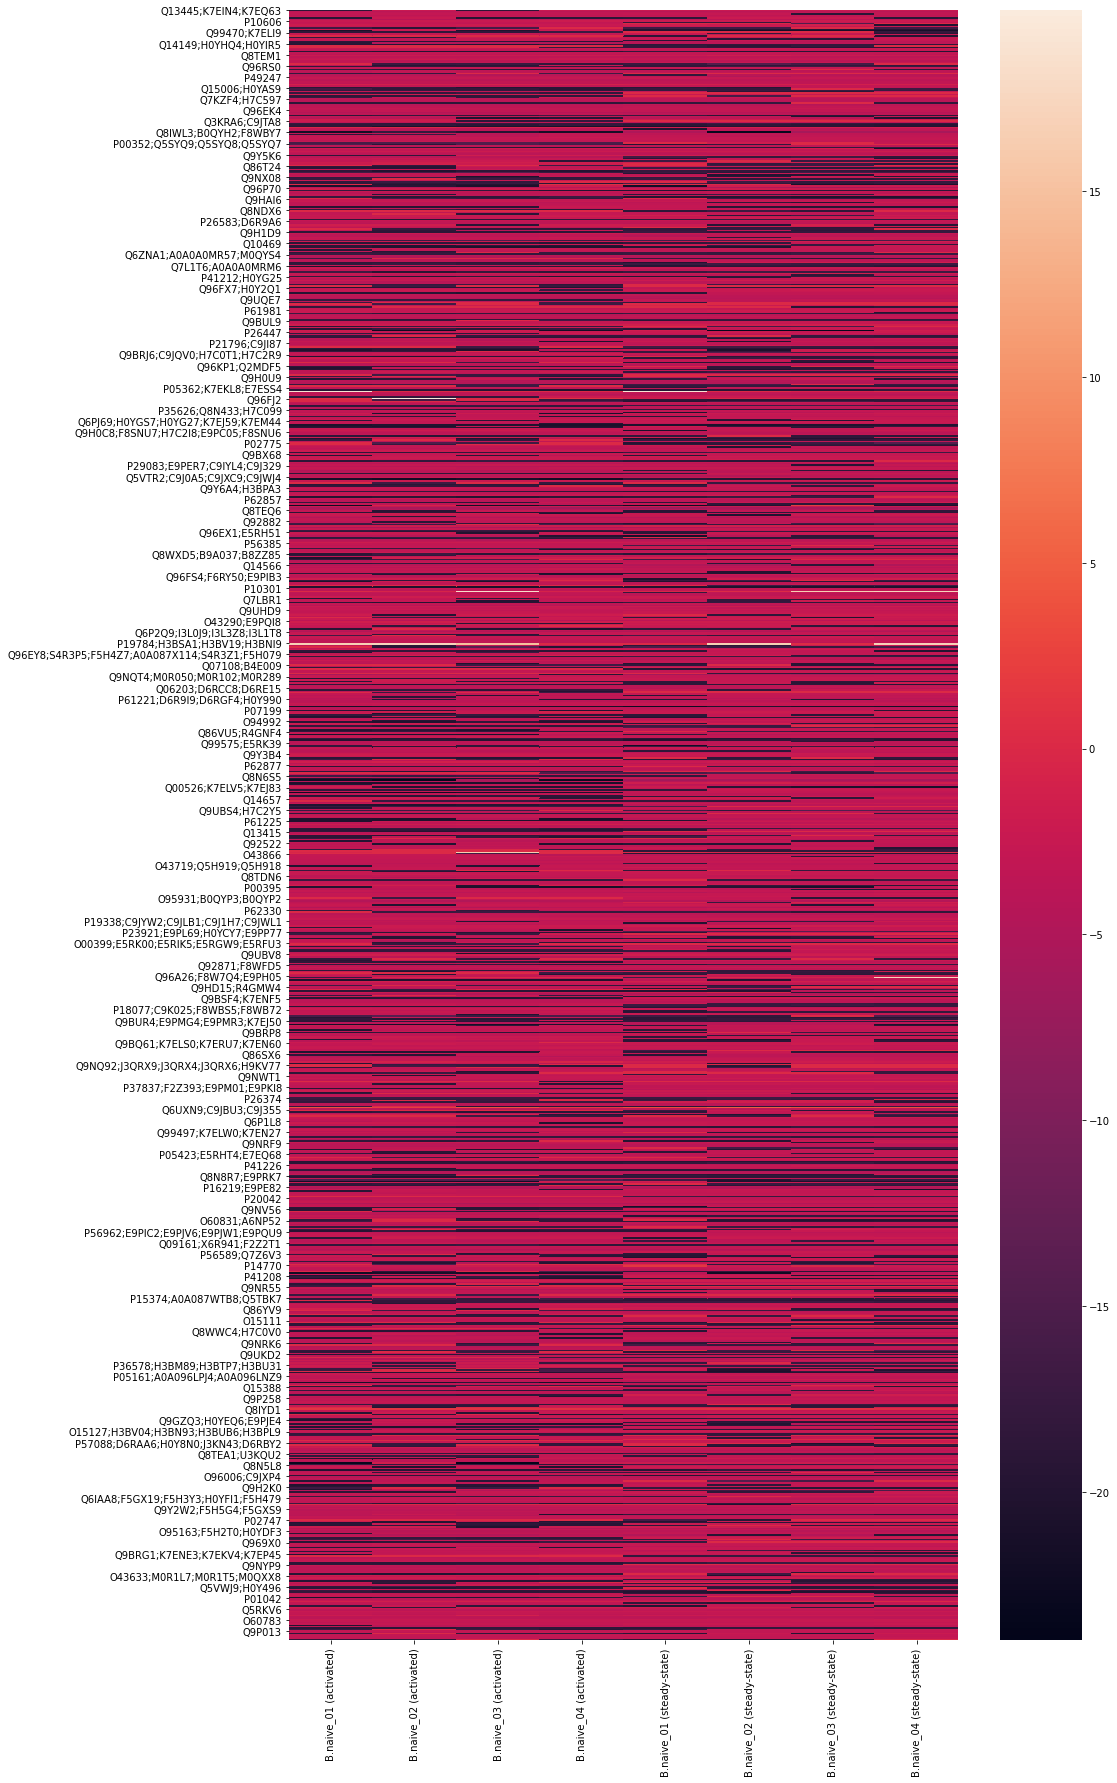

In [43]:
plt.figure(figsize=(15,30))
sns.heatmap(df_myquant.loc[common_proteins][new_intensity_columns] - 
            df_article_comp.loc[common_proteins][new_intensity_columns])
plt.show()

### Proteome difference between steady-state and activated cells

In [44]:
activated_cells = filter(lambda col: col_filter(col, state='activated'), df_article.columns)
activated_cell_lines = set(map(lambda col: re.sub(r'_.+', '', col), activated_cells))

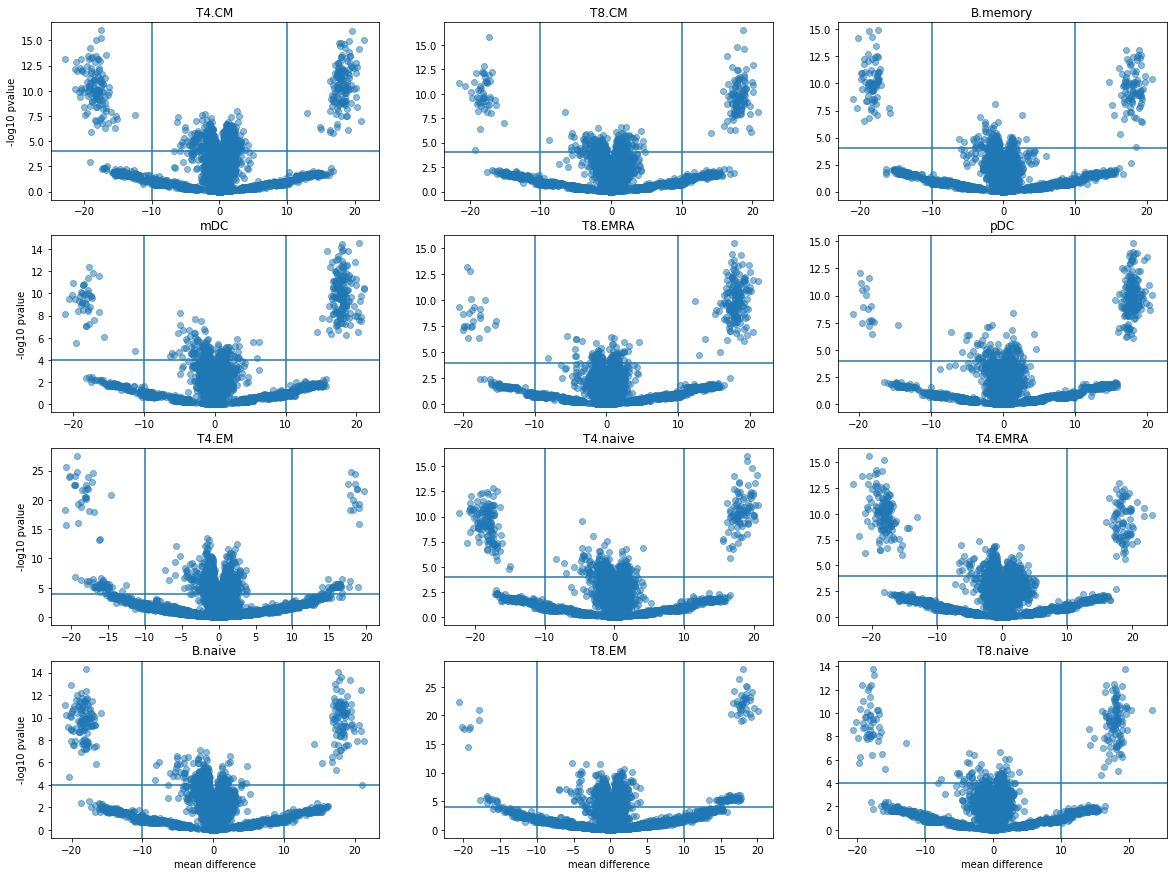

In [45]:
significantly_different_proteins = {}

fig, axes = plt.subplots(4, 3, figsize=(20,15))
axes = axes.flatten()
j = 0
for line in activated_cell_lines:
    steady_cols = list(filter(lambda col: re.match(f'{line}.+\(steady-state\)', col), df_article.columns))
    active_cols = list(filter(lambda col: re.match(f'{line}.+\(activated\)', col), df_article.columns))
    if len(steady_cols) != len(active_cols):
        continue
    df_steady = df_article[steady_cols]
    df_active = df_article[active_cols]
    result = df_article[['protein_id', 'protein_name']]
    result['-log10 pvalue'] = 0
    result['mean difference'] = 0
    for i in range(df_steady.shape[0]):
        result['-log10 pvalue'].iloc[i] = -np.log10(stats.ttest_ind(df_steady.iloc[i].values, df_active.iloc[i].values)[1])
        result['mean difference'].iloc[i] = (df_steady.iloc[i].values - df_active.iloc[i].values).mean()

    axes[j].scatter(result["mean difference"], result["-log10 pvalue"], alpha=0.5)
    axes[j].set_title(line)
    axes[j].set_xlabel('mean difference') if j in [9, 10, 11] else 0
    axes[j].set_ylabel('-log10 pvalue') if j in [0, 3, 6, 9] else 0

    axes[j].axvline(x = -10)
    axes[j].axvline(x = 10)
    axes[j].axhline(y = 4)
    j += 1
  
    diff = result[(result['-log10 pvalue'] > 4) & (np.abs(result['mean difference']) > 10)]['protein_name']
    significantly_different_proteins[line] = diff
    
plt.show()

In [46]:
significantly_different_proteins

{'T4.CM': 5                                      Neuropilin-2
 197                                      Zonadhesin
 254         ADP-ribosylation factor-like protein 15
 321                 WD repeat-containing protein 65
 423      ATP-binding cassette sub-family A member 2
                             ...                    
 20535                Angiopoietin-related protein 3
 20579          Origin recognition complex subunit 6
 20604                        Krueppel-like factor 2
 20701                                      Harmonin
 20712      Coiled-coil domain-containing protein 61
 Name: protein_name, Length: 262, dtype: object,
 'T8.CM': 26               Cysteine-rich protein 2-binding protein
 254              ADP-ribosylation factor-like protein 15
 427                                 DNA polymerase theta
 657                                            Myosin-7B
 823                Serine/threonine-protein kinase LMTK3
                               ...                       
 2